In [33]:
%matplotlib widget
import nest
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from nest import raster_plot

In [132]:
data = np.load('/home/justidy1/LabCode/IctalPlaceCell/data/line_maze_data.npz', allow_pickle=True)
wh = 9
pf_CA3 = data['all_pf_CA3'][wh]
pf_CA1 = data['all_pf_CA1'][wh]

ictal = True
if ictal:
    conn_CA3_to_CA3=data['conn_CA3_to_CA3_ictal'][wh]
    conn_CA3_to_CA1=data['conn_CA3_to_CA1_ictal'][wh]
else:
    conn_CA3_to_CA3=data['conn_CA3_to_CA3_controls'][wh]
    conn_CA3_to_CA1=data['conn_CA3_to_CA1_controls'][wh]

def stim_cue_net(conn_CA3_to_CA3,conn_CA3_to_CA1):
    # making a new newtork
    nest.ResetKernel()
    nest.SetKernelStatus({"resolution": 0.1})
    nest.local_num_threads = 16
    nest.rng_seed=1236

    # Create CA3 and CA1 populations of adaptive exponential integrate-and-fire neurons
    N_pyr = 1250
    tau_decay_pyr_e = 9.0
    tau_rise_pyr_e = 1.0
    tau_decay_pyr_i = 3.0
    tau_rise_pyr_i = 0.3
    tau_decay_gc = 5.4
    tau_rise_gc = 0.65

    pyr_spec = {'C_m':180,'g_L':4.3,'E_L':-75,'Delta_T':4.23,'V_th':-24,'V_peak':-3.25,'V_reset':-29.7,'t_ref':5.9,
                'tau_w':84.93,'a':-0.27,'b':206.84,'E_rev':[0,-90,0],
                'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i,tau_rise_gc],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i,tau_decay_gc]}
    CA3_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
    CA1_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
    # make interneurons in CA3 and CA1
    N_int = 250
    int_spec = {'C_m':118,'g_L':7.5,'E_L':-74,'Delta_T':4.6,'V_th':-57.7,'V_peak':-34.78,'V_reset':-65,'t_ref':1,
                'tau_w':178.58,'a':3.05,'b':0.91,'E_rev':[0,-90],
                'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i]}
    CA3_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)
    CA1_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)

    # connect the CA3 and CA1 populations with static synapses with the weights learned from the previous simulation
    # the order of nodes is presevered since the neurons are created in the same order
    nest.Connect(conn_CA3_to_CA3['source'], conn_CA3_to_CA3['target'], 
                'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': np.array(conn_CA3_to_CA3['weight']), 'receptor_type':1})
    nest.Connect(conn_CA3_to_CA1['source'], conn_CA3_to_CA1['target'], 
                'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': np.array(conn_CA3_to_CA1['weight']), 'receptor_type':1})

    # now we wire pyr to int with a probability of 0.1
    nest.Connect(CA3_pyr_aeif, CA3_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})
    nest.Connect(CA1_pyr_aeif, CA1_int_aeif, syn_spec={'weight': 0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})

    # connect the interneurons with each other with a probability of 0.25
    nest.Connect(CA3_int_aeif, CA3_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
    nest.Connect(CA1_int_aeif, CA1_int_aeif, syn_spec={'weight': 5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

    # and the interneurons to the pyramidal cells with a probability of 0.25
    nest.Connect(CA3_int_aeif, CA3_pyr_aeif, syn_spec={'weight': 0.65, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
    nest.Connect(CA1_int_aeif, CA1_pyr_aeif, syn_spec={'weight': 0.65, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

    # create a stim to drive all the CA3 pyramidal cells
    stim = nest.Create("poisson_generator",1,{'rate': 12.0})
    nest.Connect(stim, CA3_pyr_aeif, syn_spec={'weight': 20.0, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

    # create a cue to drive a subset of the CA3 pyramidal cells
    cue = nest.Create("inhomogeneous_poisson_generator",1,{'rate_times': [1,1000,1020],'rate_values': [0,30,0]})
    nest.Connect(cue, CA3_pyr_aeif[50:70], syn_spec={'weight': 50.0, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})
    #nest.Connect(cue, CA3_pyr_aeif[0:20], syn_spec={'weight':50.0, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})
    #nest.Connect(cue, CA3_pyr_aeif[160:165], syn_spec={'weight': 50.0, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

    # monitor the spiking activity of the CA3 and CA1 populations
    spike_detector = nest.Create("spike_recorder")
    nest.Connect(CA3_pyr_aeif, spike_detector)
    nest.Connect(CA1_pyr_aeif, spike_detector)
    nest.Connect(CA3_int_aeif, spike_detector)
    nest.Connect(CA1_int_aeif, spike_detector)
    nest.Simulate(2000)

    # get the spikes
    spikes = nest.GetStatus(spike_detector,keys='events')[0]

    return spikes

s = stim_cue_net(conn_CA3_to_CA3,conn_CA3_to_CA1)


Jul 29 16:02:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 29 16:02:32 NodeManager::prepare_nodes [Info]: 
    Preparing 3048 nodes for simulation.

Jul 29 16:02:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3048
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Not using MPI

Jul 29 16:02:35 SimulationManager::run [Info]: 
    Simulation finished.


In [133]:
s_times = s['times']
s_senders = s['senders']
s_place_CA1 = np.zeros(len(s_times))
s_place_CA3 = np.zeros(len(s_times))

for i in range(len(s_times)):
    if s_senders[i] < len(pf_CA1)+1250 and s_senders[i] >= 1250:
        s_place_CA1[i] = pf_CA1[s_senders[i]-1250]
        s_place_CA3[i] = np.nan
    elif s_senders[i] < len(pf_CA3):
        s_place_CA3[i] = pf_CA3[s_senders[i]]
        s_place_CA1[i] = np.nan
    else:
        s_place_CA1[i] = np.nan
        s_place_CA3[i] = np.nan

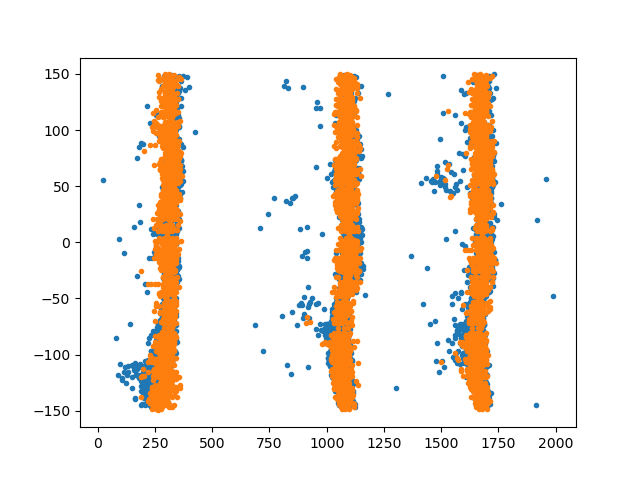

In [134]:
plt.close('all')
plt.figure()
plt.plot(s_times,s_place_CA3,'.')
plt.plot(s_times,s_place_CA1,'.')
plt.show()